In [49]:
import gensim
import re
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import RandomOverSampler
from nltk.tokenize.regexp import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier, GradientBoostingClassifier, GradientBoostingRegressor, RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, r2_score, mean_squared_error
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from matplotlib import pyplot as plt
%matplotlib inline


In [33]:
GOOGLEMODEL = gensim.models.KeyedVectors.load_word2vec_format('../data/GoogleNews-vectors-negative300.bin', binary=True)

GOOGLEMODEL['div'].shape

(300,)

In [3]:
def remove_text_between_tags(text):
    if isinstance(text, list):
        # If 'reviewText' is a list, apply the function to each element of the list
        return [re.sub(r'<.*?>.*?<.*?>', '', item) if isinstance(item, str) else item for item in text]
    elif isinstance(text, str):
        # If 'reviewText' is a string, apply the function directly
        return re.sub(r'<.*?>.*?<.*?>', '', text)
    else:
        return text


In [62]:
df = pd.read_csv('../data/full_w2v_df.csv', index_col=0)

df.info()

df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 602453 entries, 0 to 52452
Columns: 301 entries, 0 to overall
dtypes: float64(300), int64(1)
memory usage: 1.4 GB


,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,overall
0,-0.318359,0.024963,0.176758,0.101501,-0.820892,-0.135696,0.225830,-0.821472,1.262939,0.900177,...,-0.723877,-1.481628,0.516296,-0.310629,-0.918121,0.349976,-0.483765,0.867493,1.792969,4
1,0.339233,0.190918,0.002930,0.466248,0.207031,-0.756538,0.021545,-0.252197,1.321289,0.608032,...,-0.002991,-1.336182,0.439636,-0.260376,-0.344482,-0.257324,-1.484467,-0.675476,0.143860,5
2,-0.083984,0.211182,-0.395508,-0.123047,0.075684,-0.642578,-0.117188,-0.563477,0.718750,0.142822,...,-0.194580,-0.677734,0.284668,-0.110474,-0.082397,-0.073242,-0.542969,0.097656,0.243164,5
3,0.082031,0.706055,-0.333801,0.716797,0.046631,-0.020020,0.170654,0.016113,0.623535,1.138672,...,0.087402,-1.345703,0.159912,0.184570,-0.548828,0.953125,0.926270,0.387329,0.845215,5
4,0.562004,2.063141,0.641327,2.409454,-2.299713,-0.079361,2.213966,-2.263481,0.141418,6.318817,...,0.066101,-1.266113,0.831573,-0.717789,-3.124107,1.606995,-1.510742,-1.568970,1.363419,1


overall
5    416033
4     75439
1     59610
3     30642
2     20729
Name: count, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Index: 602453 entries, 0 to 52452
Columns: 300 entries, 0 to 299
dtypes: float64(300)
memory usage: 1.4 GB
<class 'pandas.core.series.Series'>
Index: 602453 entries, 0 to 52452
Series name: overall
Non-Null Count   Dtype
--------------   -----
602453 non-null  int64
dtypes: int64(1)
memory usage: 25.3 MB


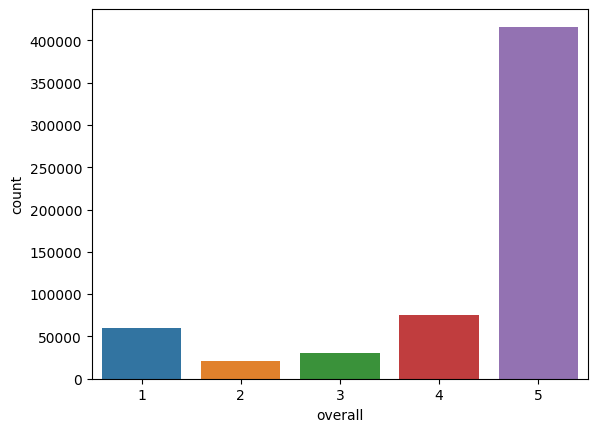

In [50]:
display(df['overall'].value_counts())

warnings.filterwarnings("ignore")

sns.countplot(x='overall', data=df)

warnings.filterwarnings("default")

features = df.drop(columns='overall')
target = df['overall']

features.info()
target.info()

In [51]:
sampler = RandomOverSampler(sampling_strategy='auto')

sampled_features, sampled_target = sampler.fit_resample(features, target)

sampled_target.value_counts()


overall
4    416033
5    416033
1    416033
3    416033
2    416033
Name: count, dtype: int64

In [53]:
scaler = MinMaxScaler()
feature_W2V = scaler.fit_transform(sampled_features)

X_train, X_test, y_train, y_test = train_test_split(feature_W2V, sampled_target, test_size=0.25, random_state=69)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1560123, 300)
(1560123,)
(520042, 300)
(520042,)


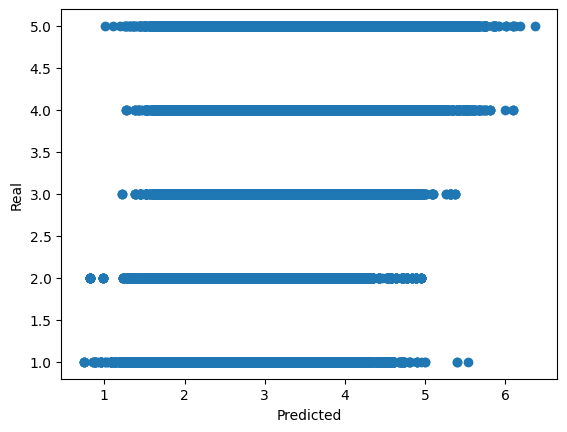

<Figure size 2000x1000 with 0 Axes>

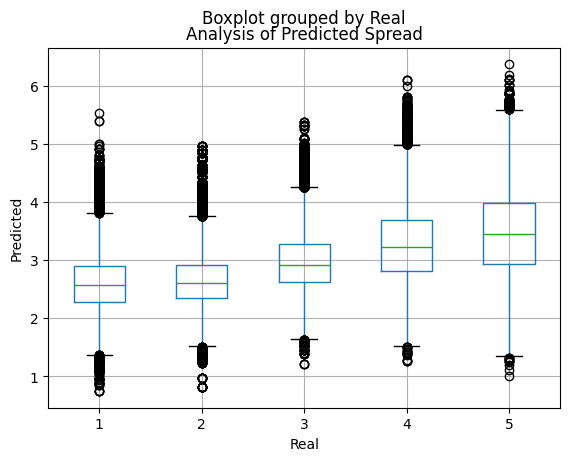

In [54]:
hgbr = HistGradientBoostingRegressor(learning_rate=0.5, max_depth=1000)
hgbr.fit(X_train, y_train)
y_pred = hgbr.predict(X_test)

y_pred_series = pd.Series(y_pred)

plt.scatter(x=y_pred, y=y_test)
plt.xlabel('Predicted')
plt.ylabel('Real');

pred_data = {
    'Predicted': y_pred,
    'Real': y_test
}

corr_df = pd.DataFrame(pred_data)

corr_df.head()

plt.figure(figsize=(20,10))
corr_df.boxplot(column='Predicted', by='Real')
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.title('Analysis of Predicted Spread');

In [55]:
y_pred_cut = pd.cut(x=y_pred, bins=[y_pred.min(),1.5,2.5,3.5,4.5,y_pred.max()], labels=[1,2,3,4,5], include_lowest=True)

orig_acc = accuracy_score(y_test, y_pred_cut)
orig_pre = precision_score(y_test, y_pred_cut, average='weighted')
orig_rec = recall_score(y_test, y_pred_cut, average='weighted')
orig_f1 = f1_score(y_test, y_pred_cut, average='weighted')
orig_r2 = r2_score(y_test, y_pred_cut)
orig_mse = mean_squared_error(y_test, y_pred_cut)

print(f'Final HGBR results:')
print(f'Accuracy: {orig_acc}\nPrecision: {orig_pre}\nRecall: {orig_rec}\nF1 Score {orig_f1}\nR Squared: {orig_r2}\nMSE: {orig_mse}')


Final HGBR results:
Accuracy: 0.2998757792639825
Precision: 0.462145746384832
Recall: 0.2998757792639825
F1 Score 0.24997488295936623
R Squared: 0.20778483437860584
MSE: 1.5840509035808645


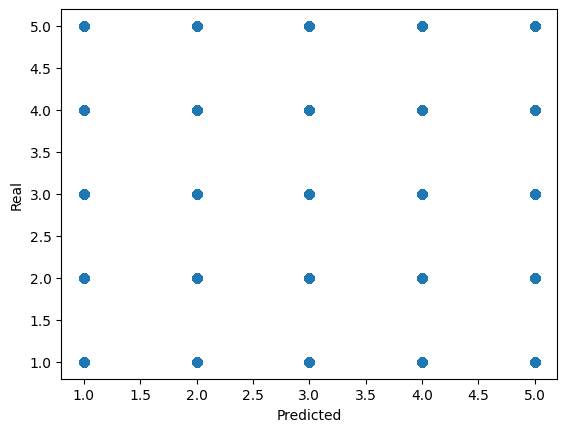

In [56]:
hgbc = HistGradientBoostingClassifier(learning_rate=0.5, max_depth=1000)
hgbc.fit(X_train, y_train)
y_pred = hgbc.predict(X_test)

y_pred_series = pd.Series(y_pred)

plt.scatter(x=y_pred, y=y_test)
plt.xlabel('Predicted')
plt.ylabel('Real');

<Figure size 2000x1000 with 0 Axes>

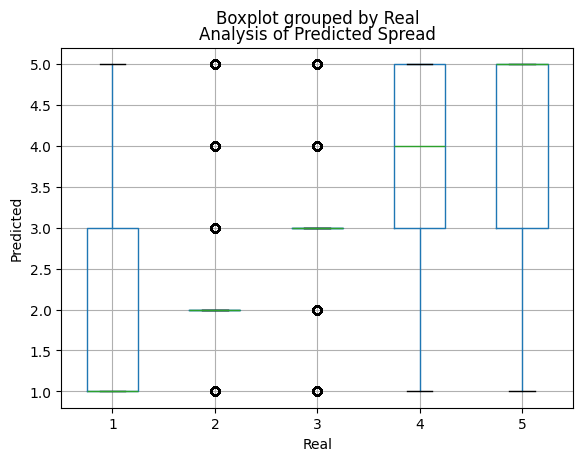

In [57]:
pred_data = {
    'Predicted': y_pred,
    'Real': y_test
}

corr_df = pd.DataFrame(pred_data)

corr_df.head()

plt.figure(figsize=(20,10))
corr_df.boxplot(column='Predicted', by='Real')
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.title('Analysis of Predicted Spread');

In [58]:
orig_acc = accuracy_score(y_test, y_pred)
orig_pre = precision_score(y_test, y_pred, average='weighted')
orig_rec = recall_score(y_test, y_pred, average='weighted')
orig_f1 = f1_score(y_test, y_pred, average='weighted')
orig_r2 = r2_score(y_test, y_pred)
orig_mse = mean_squared_error(y_test, y_pred)

print(f'Final HGBR results:')
print(f'Accuracy: {orig_acc}\nPrecision: {orig_pre}\nRecall: {orig_rec}\nF1 Score {orig_f1}\nR Squared: {orig_r2}\nMSE: {orig_mse}')


Final HGBR results:
Accuracy: 0.5558820249133724
Precision: 0.5552863853254003
Recall: 0.5558820249133724
F1 Score 0.5537096491897111
R Squared: -0.06282446361858329
MSE: 2.1251398925471405


Final HGBR results:
Accuracy: 0.9127051276627657
Precision: 0.9167046355000679
Recall: 0.9127051276627657
F1 Score 0.9136828005590572
R Squared: 0.8118210932708813
MSE: 0.3762676860715096


<Figure size 2000x1000 with 0 Axes>

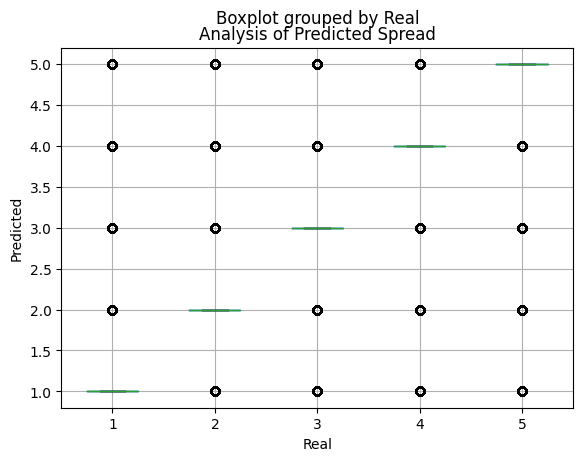

In [59]:
rf_model = RandomForestClassifier(n_jobs=-1)  # You can customize parameters here if needed
rf_model.fit(X_train, y_train)
y_pred_train_rf = rf_model.predict(X_train)
y_pred_test_rf = rf_model.predict(X_test)

pred_data = {
    'Predicted': y_pred_test_rf,
    'Real': y_test
}

corr_df = pd.DataFrame(pred_data)

corr_df.head()

plt.figure(figsize=(20,10))
corr_df.boxplot(column='Predicted', by='Real')
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.title('Analysis of Predicted Spread');

orig_acc = accuracy_score(y_test, y_pred_test_rf)
orig_pre = precision_score(y_test, y_pred_test_rf, average='weighted')
orig_rec = recall_score(y_test, y_pred_test_rf, average='weighted')
orig_f1 = f1_score(y_test, y_pred_test_rf, average='weighted')
orig_r2 = r2_score(y_test, y_pred_test_rf)
orig_mse = mean_squared_error(y_test, y_pred_test_rf)

print(f'Final HGBR results:')
print(f'Accuracy: {orig_acc}\nPrecision: {orig_pre}\nRecall: {orig_rec}\nF1 Score {orig_f1}\nR Squared: {orig_r2}\nMSE: {orig_mse}')

In [61]:
display(pd.crosstab(y_test, y_pred_test_rf, rownames=['Real'], colnames=['Predicted']))

Predicted,1,2,3,4,5
Real,,,,,
1,98187,1313,579,676,3200
2,823,99225,598,519,2790
3,617,827,95662,1912,5057
4,535,539,1254,88030,13698
5,2751,530,944,6235,93541
